<a href="https://colab.research.google.com/github/RicardoQiu/Artificial-Intelligence/blob/master/NN_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
import os

%matplotlib inline

**mount GDrive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/My\ Drive/Data

10Pipes.csv  train.npy


# **Load Training Data**

In [ ]:
data = np.float32(np.load('/content/drive/My Drive/Data/train.npy'))

In [ ]:
data.shape

In [ ]:
split_ratio = 0.2
total_num = data.shape[0]
val_num = int(total_num*split_ratio)
train_set, val_set = torch.utils.data.random_split(data, [total_num-val_num, val_num])

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

seq_len = 7
n_features = 1
batch_size = 16
epochs = 1000
lr = 2e-4
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
train_dl = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

# **Proposed RNN-based Autoencoder Neural Network**

In [14]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features=1, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
        input_size=n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
        )

        self.rnn2 = nn.LSTM(
        input_size=self.hidden_dim,
        hidden_size=embedding_dim,
        num_layers=1,
        batch_first=True
        )

    def forward(self, x):
        b_size = x.size(0)
        x = x.reshape((b_size, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((b_size, self.n_features, self.embedding_dim))


class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
        input_size=input_dim,
        hidden_size=input_dim,
        num_layers=1,
        batch_first=True
        )

        self.rnn2 = nn.LSTM(
        input_size=input_dim,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
 
        return self.output_layer(x)

In [15]:
class LSTMAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
        super(LSTMAE, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

        self.seq_len, self.n_features = seq_len, n_features

    def forward(self, x):
        x = self.encoder(x)
        x = x.repeat(1, self.seq_len, self.n_features)
        x = self.decoder(x)

        return x

# **Train the proposed neural network**

In [ ]:
lstmAE = LSTMAE(seq_len, n_features=n_features, device=device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(lstmAE.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def train(model, train_dl, criterion, optimizer, device):
    epoch_loss = 0.0
    model.train()
    for seq in train_dl:
        x = seq.to(device)
        optimizer.zero_grad()
        x_recon = model(x)

        loss = criterion(x_recon, x)

        epoch_loss += loss.item()

        loss.backward()

        optimizer.step()

    return epoch_loss / len(train_dl.dataset)

In [ ]:
def test(model, val_dl, criterion, device):
    epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for seq in val_dl:
            x = seq.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            epoch_loss += loss.item()
    
    return epoch_loss / len(val_dl.dataset)

In [ ]:
Folder = 'drive/MyDrive/cache'
best_valid_loss = float('inf')

if not os.path.exists(Folder):
    os.makedirs(Folder)

for epoch in tqdm(range(epochs)):
    train_loss = train(lstmAE, train_dl, criterion, optimizer, device)
    val_loss = test(lstmAE, val_dl, criterion, device)
    print(f"epoch:{epoch+1} [train loss: {train_loss} Val loss: {val_loss}]")

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(lstmAE.state_dict(), os.path.join(Folder, 'best-model.pt'))
    
    if epoch % 99 == 0:
        path = os.path.join(Folder, f'lstmAE_{epoch}.pt')
        torch.save(lstmAE.state_dict(), path)


# **Evaluate the proposed trained neural network on Canonical Data**

In [16]:
seq_len = 7
n_features = 1
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

lstmAE = LSTMAE(seq_len, n_features=n_features, device=device)

cuda:0


In [17]:
test_data = pd.read_csv('/content/drive/My Drive/Data/10Pipes.csv')

(319,)


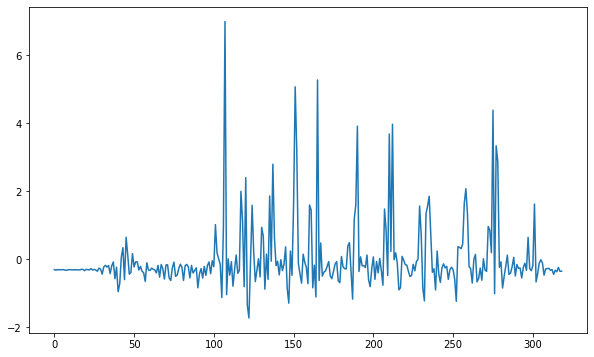

In [18]:
M1 = test_data['M1']
M1_mean = M1.mean()
M1_std = M1.std()
M1_norm = (M1-M1_mean) / M1_std
M1_norm = M1_norm.values
print(M1_norm.shape)

plt.figure(figsize=(10,6))
plt.plot(M1_norm)

In [19]:
trained_weights_path = '/content/drive/My Drive/cache/best-model.pt'
lstmAE.load_state_dict(torch.load(trained_weights_path))

<All keys matched successfully>

(313, 7, 1)
(313,)
7.548912e-07 0.2673374 0.7355358


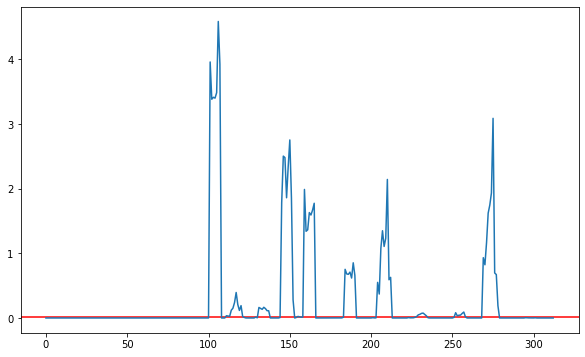

In [20]:
window_size = 7
stride = 1
sq_T = M1_norm.shape[0]
num_seq = (sq_T - window_size) // stride + 1
threshold = 1e-2

indices = (np.arange(window_size) + np.arange(0, num_seq, stride).reshape(-1,1)).reshape(-1,)
sliding_windows = M1_norm[indices].reshape(-1, window_size, 1)
print(sliding_windows.shape)
sliding_windows = torch.tensor(sliding_windows, dtype=torch.float32).to(device)
out = lstmAE(sliding_windows)
error = ((out - sliding_windows)**2).mean(dim=(1,2)).detach().cpu().numpy() 
print(error.shape)

print(error.min(), error.mean(), error.std())

plt.figure(figsize=(10,6))
plt.axhline(y=threshold, color='r', linestyle='-')
plt.plot(error)

# **Find the candidates and post-process the result**

In [21]:
candidate_windows = np.where(error > threshold)[0]
seg_candidates = np.split(candidate_windows, np.where(np.diff(candidate_windows)>2)[0] + 1)

**Visualize the Segmented Results**

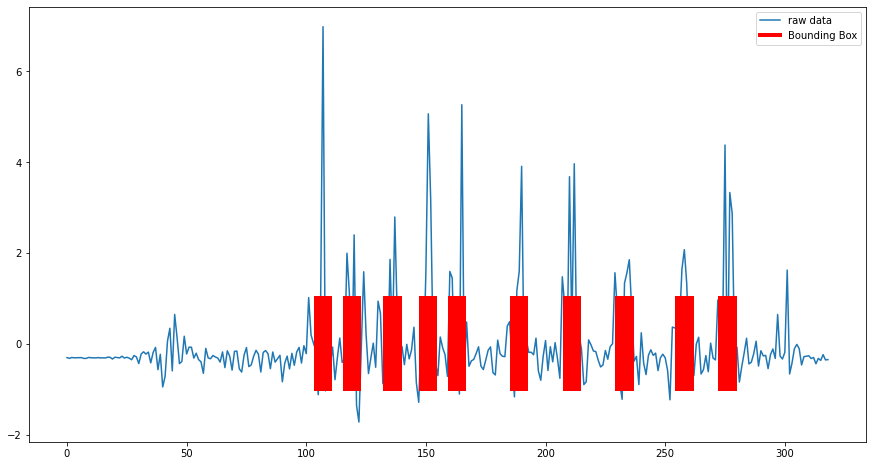

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(M1_norm, label="raw data")

plot_indices = indices.reshape(-1, window_size)

plt.plot(plot_indices[int(seg_candidates[0].mean())], [-1]*window_size, color='red', linewidth=4, label='Bounding Box')

for cand in seg_candidates:
    window = plot_indices[int(cand.mean())]
    plt.plot(window, [-1]*window_size, color='red', linewidth=4)
    plt.plot(window, [1]*window_size, color='red', linewidth=4)
    plt.plot([window, window], [-1, 1], color='red', linewidth=4)
    # plt.plot(window+window_size, [-1]*window_size, color='red', linewidth=4)

plt.legend()

# **Export To PDF**

In [5]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-

In [11]:
%cd Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [23]:
!jupyter nbconvert --to pdf NN_detection.ipynb

[NbConvertApp] Converting notebook NN_detection.ipynb to pdf
[NbConvertApp] Writing 49345 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 43197 bytes to NN_detection.pdf
